# Основы глубинного обучения, майнор ИАД

## Домашнее задание 1. Введение в PyTorch. Полносвязные нейронные сети.

### Общая информация

Дата выдачи: 06.10.2021

Мягкий дедлайн: 23:59MSK 25.10.2021

Жесткий дедлайн: 23:59MSK 28.10.2021

### Оценивание и штрафы
Максимально допустимая оценка за работу — 10 баллов. За каждый день просрочки снимается 1 балл. Сдавать задание после жёсткого дедлайна сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.
Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит предсказывать год выпуска песни по некоторым звуковым признакам: [данные](https://archive.ics.uci.edu/ml/datasets/yearpredictionmsd). В ячейках ниже находится код для загрузки данных. Обратите внимание, что обучающая и тестовая выборки располагаются в одном файле, поэтому НЕ меняйте ячейку, в которой производится деление данных.

In [1]:
import torch
from torch import nn
import pandas as pd
import numpy as np
import random

In [2]:
!wget -O data.txt.zip https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip

--2021-10-26 14:34:27--  https://archive.ics.uci.edu/ml/machine-learning-databases/00203/YearPredictionMSD.txt.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 211011981 (201M) [application/x-httpd-php]
Saving to: ‘data.txt.zip’

data.txt.zip        100%[===================>] 201.24M  19.4MB/s    in 12s     

2021-10-26 14:34:39 (17.3 MB/s) - ‘data.txt.zip’ saved [211011981/211011981]



In [3]:
df = pd.read_csv('data.txt.zip', header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90
0,2001,49.94357,21.47114,73.07750,8.74861,-17.40628,-13.09905,-25.01202,-12.23257,7.83089,-2.46783,3.32136,-2.31521,10.20556,611.10913,951.08960,698.11428,408.98485,383.70912,326.51512,238.11327,251.42414,187.17351,100.42652,179.19498,-8.41558,-317.87038,95.86266,48.10259,-95.66303,-18.06215,1.96984,34.42438,11.72670,1.36790,7.79444,-0.36994,-133.67852,-83.26165,-37.29765,...,-25.38187,-3.90772,13.29258,41.55060,-7.26272,-21.00863,105.50848,64.29856,26.08481,-44.59110,-8.30657,7.93706,-10.73660,-95.44766,-82.03307,-35.59194,4.69525,70.95626,28.09139,6.02015,-37.13767,-41.12450,-8.40816,7.19877,-8.60176,-5.90857,-12.32437,14.68734,-54.32125,40.14786,13.01620,-54.40548,58.99367,15.37344,1.11144,-23.08793,68.40795,-1.82223,-27.46348,2.26327
1,2001,48.73215,18.42930,70.32679,12.94636,-10.32437,-24.83777,8.76630,-0.92019,18.76548,4.59210,2.21920,0.34006,44.38997,2056.93836,605.40696,457.41175,777.15347,415.64880,746.47775,366.45320,317.82946,273.07917,141.75921,317.35269,19.48271,-65.25496,162.75145,135.00765,-96.28436,-86.87955,17.38087,45.90742,32.49908,-32.85429,45.10830,26.84939,-302.57328,-41.71932,-138.85034,...,28.55107,1.52298,70.99515,-43.63073,-42.55014,129.82848,79.95420,-87.14554,-45.75446,-65.82100,-43.90031,-19.45705,12.59163,-407.64130,42.91189,12.15850,-88.37882,42.25246,46.49209,-30.17747,45.98495,130.47892,13.88281,-4.00055,17.85965,-18.32138,-87.99109,14.37524,-22.70119,-58.81266,5.66812,-19.68073,33.04964,42.87836,-9.90378,-32.22788,70.49388,12.04941,58.43453,26.92061
2,2001,50.95714,31.85602,55.81851,13.41693,-6.57898,-18.54940,-3.27872,-2.35035,16.07017,1.39518,2.73553,0.82804,7.46586,699.54544,1016.00954,594.06748,355.73663,507.39931,387.69910,287.15347,112.37152,161.68928,144.14353,199.29693,-4.24359,-297.00587,-148.36392,-7.94726,-18.71630,12.77542,-25.37725,9.71410,0.13843,26.79723,6.30760,28.70107,-74.89005,-289.19553,-166.26089,...,18.50939,16.97216,24.26629,-10.50788,-8.68412,54.75759,194.74034,7.95966,-18.22685,0.06463,-2.63069,26.02561,1.75729,-262.36917,-233.60089,-2.50502,-12.14279,81.37617,2.07554,-1.82381,183.65292,22.64797,-39.98887,43.37381,-31.56737,-4.88840,-36.53213,-23.94662,-84.19275,66.00518,3.03800,26.05866,-50.92779,10.93792,-0.07568,43.20130,-115.00698,-0.05859,39.67068,-0.66345
3,2001,48.24750,-1.89837,36.29772,2.58776,0.97170,-26.21683,5.05097,-10.34124,3.55005,-6.36304,6.63016,-3.35142,37.64085,2174.08189,697.43346,459.24587,742.78961,229.30783,387.89697,249.06662,245.89870,176.20527,98.82222,150.97286,78.49057,-62.00282,43.49659,-96.42719,-108.96608,14.22854,14.54178,-23.55608,-39.36953,-43.59209,20.83714,35.63919,-181.34947,-93.66614,-90.55616,...,4.56917,-37.32280,4.15159,12.24315,35.02697,-178.89573,82.46573,-20.49425,101.78577,-19.77808,-21.52657,3.36303,-11.63176,51.55411,-50.57576,-28.14755,-83.15795,-7.35260,-22.11505,1.18279,-122.70467,150.57360,24.37468,41.19821,-37.04318,-28.72986,162.19614,22.18309,-8.63509,85.23416,34.57337,-171.70734,-16.96705,-46.67617,-12.51516,82.58061,-72.08993,9.90558,199.62971,18.85382
4,2001,50.97020,42.20998,67.09964,8.46791,-15.85279,-16.81409,-12.48207,-9.37636,12.63699,0.93609,1.60923,2.19223,47.32082,894.28471,809.86615,318.78559,435.04497,341.61467,334.30734,322.99589,190.61921,235.84715,96.89517,210.58870,5.60463,-199.63958,204.85812,-77.17695,-65.79741,-6.95097,-12.15262,-3.85410,20.68990,-20.30480,37.15045,11.20673,-124.09519,-295.98542,-33.31169,...,45.25506,10.42226,27.88782,-17.12676,-31.54772,-76.86293,41.17343,-138.32535,-53.96905,-21.30266,-24.87362,-2.46595,-4.05003,-56.51161,-34.56445,-5.07092,-47.75605,64.81513,-97.42948,-12.59418,55.23699,28.85657,54.53513,-31.97077,20.03279,-8.07892,-55.12617,26.58961,-10.27183,-30.64232,9.92661,-55.95724,64.92712,-17.72522,-1.49237,-7.50035,51.76631,7.88713,55.6

In [15]:
463715/df.shape[0]

0.8998146872483482

In [16]:
#df = df.sample(100000)

In [4]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

train_size = 463715
X_train = X[:train_size, :]
y_train = y[:train_size]
X_test = X[train_size:, :]
y_test = y[train_size:]

In [5]:
from sklearn.preprocessing import StandardScaler

In [6]:
Xscaler = StandardScaler()
X_train = Xscaler.fit_transform(X_train)
X_test = Xscaler.transform(X_test)
yscaler = StandardScaler()
y_train = yscaler.fit_transform(y_train.reshape(-1, 1))
y_test = yscaler.transform(y_test.reshape(-1, 1))


## Задание 0. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Мы будем использовать RMSE как метрику качества. Для самого первого бейзлайна обучите `Ridge` регрессию из `sklearn`. Кроме того, посчитайте качество при наилучшем константном прогнозе.

In [7]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [8]:
model = Ridge()
model.fit(X_train, y_train)
print(mean_squared_error(yscaler.inverse_transform(model.predict(X_test)), yscaler.inverse_transform(y_test), squared = False))

9.510160820470437


In [9]:
mean_squared_error (np.full(len(y_test),yscaler.inverse_transform(y_train).mean()), yscaler.inverse_transform(y_test), squared = False)

10.85246390513634

In [10]:
import seaborn as sns

Text(0.5, 1.0, 'количество таргетов в каждый год')

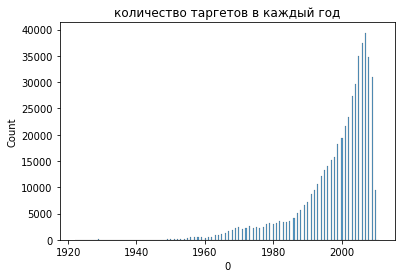

In [146]:
sns.histplot(data = df, x = 0).set_title('количество таргетов в каждый год')

## Задание 1. (максимум 10 баллов)

Реализуйте обучение и тестирование нейронной сети для предоставленного вам набора данных. Соотношение между полученным значением метрики на тестовой выборке и баллами за задание следующее:

- $\text{RMSE} \le 9.00 $ &mdash; 4 балла
- $\text{RMSE} \le 8.90 $ &mdash; 6 баллов
- $\text{RMSE} \le 8.80 $ &mdash; 8 баллов
- $\text{RMSE} \le 8.75 $ &mdash; 10 баллов

Есть несколько правил, которых вам нужно придерживаться:

- Весь пайплайн обучения должен быть написан на PyTorch. При этом вы можете пользоваться другими библиотеками (`numpy`, `sklearn` и пр.), но только для обработки данных. То есть как угодно трансформировать данные и считать метрики с помощью этих библиотек можно, а импортировать модели из `sklearn` и выбивать с их помощью требуемое качество &mdash; нельзя. Также нельзя пользоваться библиотеками, для которых сам PyTorch является зависимостью.

- Мы никак не ограничиваем ваш выбор архитектуры модели, но скорее всего вам будет достаточно полносвязной нейронной сети.

- Для обучения запрещается использовать какие-либо иные данные, кроме обучающей выборки.

- Ансамблирование моделей запрещено.

### Полезные советы:

- Очень вряд ли, что у вас с первого раза получится выбить качество на 10 баллов, поэтому пробуйте разные архитектуры, оптимизаторы и значения гиперпараметров. В идеале при запуске каждого нового эксперимента вы должны менять что-то одно, чтобы точно знать, как этот фактор влияет на качество.

- Тот факт, что мы занимаемся глубинным обучением, не означает, что стоит забывать про приемы, использующиеся в классическом машинном обучении. Так что обязательно проводите исследовательский анализ данных, отрисовывайте нужные графики и не забывайте про масштабирование и подбор гиперпараметров.

- Вы наверняка столкнетесь с тем, что ваша нейронная сеть будет сильно переобучаться. Для нейросетей существуют специальные методы регуляризации, например, dropout ([статья](https://jmlr.org/papers/volume15/srivastava14a/srivastava14a.pdf)) и weight decay ([блогпост](https://towardsdatascience.com/weight-decay-l2-regularization-90a9e17713cd)). Они, разумеется, реализованы в PyTorch. Попробуйте поэкспериментировать с ними.

- Если вы чего-то не знаете, не гнушайтесь гуглить. В интернете очень много полезной информации, туториалов и советов по глубинному обучению в целом и по PyTorch в частности. Но не забывайте, что за скатанный код без ссылки на источник придется ответить по всей строгости!

- Если вы сразу реализуете обучение на GPU, то у вас будет больше времени на эксперименты, так как любые вычисления будут работать быстрее. Google Colab предоставляет несколько GPU-часов (обычно около 8-10) в сутки бесплатно.

- Чтобы отладить код, можете обучаться на небольшой части данных или даже на одном батче. Если лосс на обучающей выборке не падает, то что-то точно идет не так!

- Пользуйтесь утилитами, которые вам предоставляет PyTorch (например, Dataset и Dataloader). Их специально разработали для упрощения разработки пайплайна обучения.

- Скорее всего вы захотите отслеживать прогресс обучения. Для создания прогресс-баров есть удобная библиотека `tqdm`.

- Быть может, вы захотите, чтобы графики рисовались прямо во время обучения. Можете воспользоваться функцией [clear_output](http://ipython.org/ipython-doc/dev/api/generated/IPython.display.html#IPython.display.clear_output), чтобы удалять старый график и рисовать новый на его месте.

**ОБЯЗАТЕЛЬНО** рисуйте графики зависимости лосса/метрики на обучающей и тестовой выборках в зависимости от времени обучения. Если обучение занимает относительно небольшое число эпох, то лучше рисовать зависимость от номера шага обучения, если же эпох больше, то рисуйте зависимость по эпохам. Если проверяющий не увидит такого графика для вашей лучшей модели, то он в праве снизить баллы за задание.

**ВАЖНО!** Ваше решение должно быть воспроизводимым. Если это не так, то проверяющий имеет право снизить баллы за задание. Чтобы зафиксировать random seed, воспользуйтесь функцией из ячейки ниже.



In [12]:
def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

In [13]:
set_random_seed(13)

Вы можете придерживаться любой адекватной струкуры кода, но мы советуем воспользоваться следующими сигнатурами функций. Лучше всего, если вы проверите ваши предсказания ассертом: так вы убережете себя от разных косяков, например, что вектор предсказаний состоит из всего одного числа. В любом случае, внимательно следите за тем, для каких тензоров вы считаете метрику RMSE. При случайном или намеренном введении в заблуждение проверяющие очень сильно разозлятся.

In [14]:
class ds(torch.utils.data.Dataset):

    def __init__(self, X_train, y_train, transform=None):
        self.X_train = X_train
        self.y_train = y_train

    def __len__(self):
        return len(self.y_train)

    def __getitem__(self, idx):
        return  torch.tensor(self.X_train[idx, :], dtype=torch.float), torch.tensor(self.y_train[idx],dtype=torch.float)

In [67]:
len(np.unique(y_train))

89

In [133]:
train_set = ds(X_train,y_train)
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=False)

test_set = ds(X_test,y_test)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)

model = nn.Sequential(
    nn.Linear(90, 300),
    nn.ReLU(),
    nn.Linear(300, 70),
    nn.ReLU(),
    nn.Linear(70, 1))
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001) 
criterion = nn.MSELoss()
model = model.to(device ="cuda:0" )

In [91]:
YTRAIN = y_train

In [134]:
!pip install wandb --upgrade --quiet
import wandb

# логинимся в своего пользователя (предварительно нужно ввести ключ из настроек с wandb.ai через консоль)
wandb.login()
# инициализируем проект
wandb.init(project="ht_1")
# сохраняем параметры сетки в wandb + просим следить за градиентами сетки
wandb.watch(model);

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


In [56]:
from sklearn.metrics import mean_squared_error

In [57]:
from tqdm.notebook import tqdm

In [135]:
def train(model, optimizer, criterion, train_loader, test_loader):
    '''
    params:
        model - torch.nn.Module to be fitted
        optimizer - model optimizer
        criterion - loss function from torch.nn
        train_loader - torch.utils.data.Dataloader with train set
        test_loader - torch.utils.data.Dataloader with test set
                      (if you wish to validate during training)
    '''
    for epoch in range(16):
        mean_train_loss = []
        model.train()
        for x_train, y_train in tqdm(train_loader):    # берем батч из трейн лоадера
            x_train = x_train.to(device ="cuda:0" )
            y_train = y_train.to(device ="cuda:0" )
            y_pred = model(x_train)                        # делаем предсказания
            loss = torch.sqrt(criterion(y_pred, y_train))        # считаем лосс
            loss.backward()                                # считаем градиенты обратным проходом
            optimizer.step()                               # обновляем параметры сети
            optimizer.zero_grad()                          # обнуляем посчитанные градиенты параметров
        

        pred_test = np.array(test(model, criterion, test_loader).tolist())
        pred_train = np.array(test(model, criterion, train_loader).tolist())

        val_loss = mean_squared_error(yscaler.inverse_transform(pred_test),
                                        yscaler.inverse_transform(y_test), squared = False)
        train_loss = mean_squared_error(yscaler.inverse_transform(pred_train),
                                        yscaler.inverse_transform(YTRAIN), squared = False) #считается долго но это первое что в голову пришло
        
            # скидываем метрики на wandb и автоматом смотрим на графики
        wandb.log({"mean val loss": val_loss, "mean train loss":train_loss})
                     # "mean val accuracy": np.mean(val_accuracy)})
            
            # печатаем метрики
        print(f"Epoch: {epoch}, loss: {np.mean(val_loss)}") #, accuracy: {np.mean(val_accuracy)}")


def test(model, criterion, test_loader):
    '''
    params:
        model - torch.nn.Module to be evaluated on test set
        criterion - loss function from torch.nn
        test_loader - torch.utils.data.Dataloader with test set
    ----------
    returns:
        predicts - torch.tensor with shape (len(test_loader.dataset), ),
                   which contains predictions for test objects
    '''
    model.eval()
    predicts = torch.zeros(0).to(device ="cuda:0" )
    with torch.no_grad():                          # на валидации запрещаем фреймворку считать градиенты по параметрам
        for x_val, y_val in tqdm(test_loader):  # берем батч из вал лоадера
            x_val = x_val.to(device ="cuda:0" )  
            predicts = torch.cat((predicts, model(x_val)), 0) #https://discuss.pytorch.org/t/efficient-method-to-gather-all-predictions/8008/5
    return predicts

In [136]:
train(model, optimizer, criterion, train_loader, test_loader)

  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 0, loss: 9.116806230360428


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 1, loss: 8.997536341991665


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 2, loss: 8.9393819122181


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 3, loss: 8.901676803821887


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 4, loss: 8.876851333169776


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 5, loss: 8.857170403298376


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 6, loss: 8.84243183169613


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 7, loss: 8.830234446649664


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 8, loss: 8.821021713144052


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 9, loss: 8.813739101682417


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 10, loss: 8.807578987192276


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 11, loss: 8.803459245487668


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 12, loss: 8.80187476194782


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 13, loss: 8.802397244250717


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 14, loss: 8.800992395202893


  0%|          | 0/7246 [00:00<?, ?it/s]

  0%|          | 0/807 [00:00<?, ?it/s]

  0%|          | 0/7246 [00:00<?, ?it/s]

Epoch: 15, loss: 8.801503602978526


In [137]:
assert test(model, criterion, test_loader).shape[0] == y_test.shape[0]

  0%|          | 0/807 [00:00<?, ?it/s]

## Задание 2. (0 баллов, но при невыполнении максимум за все задание &mdash; 0 баллов)

Напишите небольшой отчет о том, как вы добились полученного качества: какие средства использовали и какие эксперименты проводили. Подробно расскажите об архитектурах и значениях гиперпараметров, а также какие метрики на тесте они показывали. Чтобы отчет был зачтен, необходимо привести хотя бы 3 эксперимента.

это лучшая модель (не лучшая но я если честно забыла какая лучшая):

In [138]:
prediction = yscaler.inverse_transform(np.array(test(model, criterion, test_loader).cpu()))

  0%|          | 0/807 [00:00<?, ?it/s]

In [139]:
Y_test = yscaler.inverse_transform(y_test)

In [140]:
dfka = pd.DataFrame(prediction)

In [141]:
dfka['pred'] = pd.DataFrame(yscaler.inverse_transform(y_test))

Text(0.5, 1.0, 'плотность распределения таргета в предсказании и в тесте')

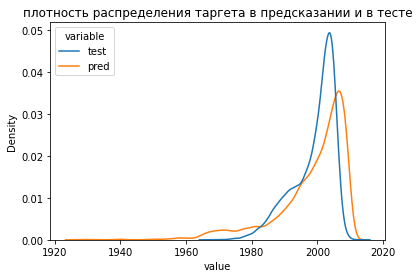

In [147]:
dfka.rename(columns = {0: 'test'}, inplace = True)
melted = dfka.melt()
sns.kdeplot(data = melted, x = 'value', hue = 'variable').set_title('плотность распределения таргета в предсказании и в тесте')

Text(0.5, 1.0, 'зависимость предсказания и теста')

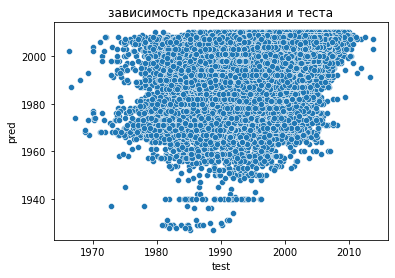

In [148]:
sns.scatterplot(data = dfka, x = 'test', y = 'pred').set_title('зависимость предсказания и теста')

In [144]:
mean_squared_error(Y_test, prediction, squared = False)

8.801504070134554

на самом деле я так рада что у меня ошибка падать начала !!!!
теперь есть 3 штуки которые я в силах поменять: батч сайз, lr, саму архитектуру. 
еще, быть может, попробую pca (однокурсник пробовал, у него прибавки не дало, но я думаю можно попробовать взять не все компоненты, а первые 2-3 и добавить просто к имеющимся фичам)

а, вот еще я не пробовала пока дропаут

я если честно пока не знаю как делать гридсерч с нейросетками__ так что пока буду перебирать руками и смотреть че как (тем более у меня времени не хватит перебирать сетку гиперпараметров, поэтому будем действовать жадно и наугад)

## подбор батчсайза

пока дефолтные параметры такие:
lr = 10^-4
архитектура:
model = nn.Sequential(
    nn.Linear(90, 100),
    nn.ReLU(),
    nn.Linear(100, 70),
    nn.ReLU(),
    nn.Linear(70, 1)). 
10 эпох

батчсайз 
40 - 8.886811052846696

64 - loss: 8.86269474077881

100 - 8.869375349956997

1000 (по приколу) - 8.989616284714007

upd я вспомнила что лучше брать степени двойки но уже поздно. но по итогу 64 берем

## подбор lr

10^(-3) - 8.919459246732751

10^(-4) - 8.86269474077881

10^(-5) - 9.213955462155306

сейчас я поменяла число нейронов посередке с 70 на 89 (из соображений того что у нас "классов" 89) и лосс подрос до 8.871172193699053. попробую сделать 50, вдруг что-то прикольное будет (нет - 8.899113247501685)

думаю это считается за 3 эксперимента, я устала в общем

окей я попробовала количество выходных на первом слое увеличить до 120 и чуууть-чуть качество подросло - лосс теперь 8.859407121905393. а на 150 так вообще 8.845121082816581

170 - 8.842966870988718

200 - 8.839462603584753

# ура

я оставила 200 выходов на первом слое и увеличила количество эпох - теперь не 10, а 30 ну и короче чудо случилось там лосс упал немножко, потом я 300 выходов поставила!! он еще сильнее упал!! да как так-то!

итоговая модель у меня с очень простой архитектурой - там нет никаких специальных методов регуляризации, просто полносвязные слои и нелинейности (нелинейности кстати с дефолтными параметрами). для предобработки я использовала standard scaler как для train, так и для test, а для подсчета ошибки переводила все обратно в изначальные единицы. ошибка везде - rmse, на ней как обучение, так и проверка. learning rate моей модели +- стандартный - 10^-4, как и количество батчей - 64. в качестве оптимайзера был использован adam, я, кстати, не знаю, есть ли смысл в его adagrad-ной части применимо конкретно к этим данным: они не разреженные. 

качество моей модели можно посмотреть по ссылке: https://wandb.ai/gu1ldenstern/ht_1?workspace=user-gu1ldenstern

не знаю кто это будет проверять но сил вам наверное конкретно эта домашка у всех будет ужасно проверяться